# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

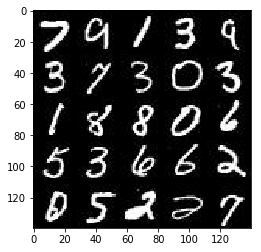

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


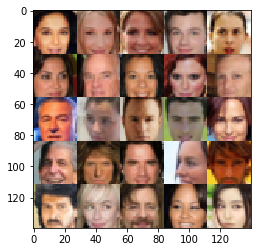

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real=tf.placeholder(dtype=tf.float32,shape=[None,image_width,image_height,image_channels],name="real")
    z=tf.placeholder(dtype=tf.float32,shape=[None,z_dim],name="z")
    learning_rate=tf.placeholder(dtype=tf.float32,name="lr")
    return real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(tensor,alpha):
    return tf.maximum(alpha * tensor, tensor)

In [7]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = leaky_relu(x1,alpha)


        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.01),
                              use_bias=False, bias_initializer=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(x2,alpha)

        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',
                              kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.01),
                              use_bias=False, bias_initializer=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(x3,alpha)

        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1, 
                                 kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.01),
                                 activation=None)
        out = tf.sigmoid(logits)


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not(is_train)):

        x1 = tf.layers.dense(z, 7*7*512, 
                             kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.01),
                             use_bias=False, bias_initializer=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1,alpha)


        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.01),
                                        use_bias=False, bias_initializer=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2,alpha)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.01),
                                        use_bias=False, bias_initializer=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3,alpha)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same', 
                                        kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.01),
                                        use_bias=False, bias_initializer=None)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = leaky_relu(x4,alpha)
        

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, 
                                            kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.01),
                                            padding='same')
        #logits=tf.image.resize_images(logits, (28, 28))
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=0.2)
    d_model_real, d_logits_real = discriminator(input_real, alpha=0.2)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=0.2)

    smooth = 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*(1 - smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1 - smooth)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape, data_image_mode)
    if(data_image_mode=="L"):image_channels=1
    elif(data_image_mode=="RGB"):image_channels=3
    else: raise error
    #print((data_shape[1], data_shape[1], image_channels, z_dim))
    real, z, lr=model_inputs(data_shape[1], data_shape[1], image_channels, z_dim)
    d_loss, g_loss=model_loss(real, z, image_channels,alpha=0.2)
    d_train_opt, g_train_opt=model_opt(d_loss, g_loss, lr, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for i,batch_images in enumerate(get_batches(batch_size)):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                if i%10==0:
                    train_loss_d = d_loss.eval({z: batch_z, real: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})
                    total_loss = train_loss_d + train_loss_g
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Total loss: {:.4f}".format(total_loss))
                if i%100 ==0:show_generator_output(sess, 16, z, image_channels, data_image_mode)

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={lr:learning_rate,real: batch_images, z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={lr:learning_rate,z: batch_z})
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.5118


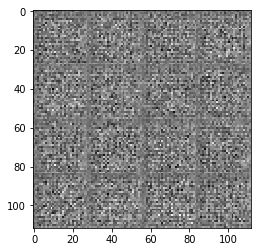

Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 0.4751
Epoch 1/2... Discriminator Loss: 0.5490... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 0.3634... Generator Loss: 0.4019
Epoch 1/2... Discriminator Loss: 0.3588... Generator Loss: 0.4113
Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 0.4014
Epoch 1/2... Discriminator Loss: 0.4453... Generator Loss: 0.4776
Epoch 1/2... Discriminator Loss: 0.4143... Generator Loss: 0.3378
Epoch 1/2... Discriminator Loss: 0.3907... Generator Loss: 0.4220
Epoch 1/2... Discriminator Loss: 0.3725... Generator Loss: 0.3677
Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 0.3565


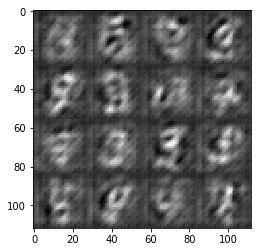

Epoch 1/2... Discriminator Loss: 0.3819... Generator Loss: 0.3507
Epoch 1/2... Discriminator Loss: 0.3826... Generator Loss: 0.3482
Epoch 1/2... Discriminator Loss: 0.4069... Generator Loss: 0.3347
Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 0.3830
Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 0.4134
Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 0.4267
Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 0.3615
Epoch 1/2... Discriminator Loss: 0.4413... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 0.3754... Generator Loss: 0.3842
Epoch 1/2... Discriminator Loss: 0.3649... Generator Loss: 0.3761


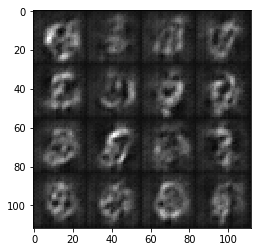

Epoch 1/2... Discriminator Loss: 0.3708... Generator Loss: 0.3622
Epoch 1/2... Discriminator Loss: 0.3624... Generator Loss: 0.3867
Epoch 1/2... Discriminator Loss: 0.3716... Generator Loss: 0.4174
Epoch 1/2... Discriminator Loss: 0.3654... Generator Loss: 0.3956
Epoch 1/2... Discriminator Loss: 0.3709... Generator Loss: 0.3638
Epoch 1/2... Discriminator Loss: 0.3828... Generator Loss: 0.3488
Epoch 1/2... Discriminator Loss: 0.4267... Generator Loss: 0.5106
Epoch 1/2... Discriminator Loss: 0.3684... Generator Loss: 0.3717
Epoch 1/2... Discriminator Loss: 0.3712... Generator Loss: 0.3626
Epoch 1/2... Discriminator Loss: 0.3862... Generator Loss: 0.3501


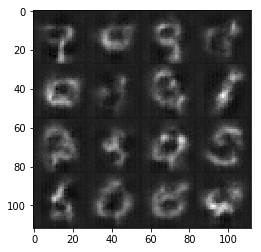

Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 0.4271
Epoch 1/2... Discriminator Loss: 0.3756... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 0.3887... Generator Loss: 0.3488
Epoch 1/2... Discriminator Loss: 0.4049... Generator Loss: 0.4609
Epoch 1/2... Discriminator Loss: 0.4043... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 0.4302... Generator Loss: 0.5226
Epoch 1/2... Discriminator Loss: 0.3671... Generator Loss: 0.3931
Epoch 1/2... Discriminator Loss: 0.3773... Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 0.3702... Generator Loss: 0.3969
Epoch 1/2... Discriminator Loss: 0.3807... Generator Loss: 0.3551


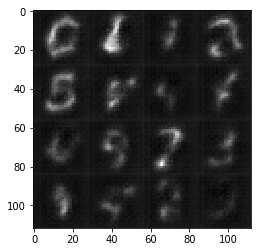

Epoch 1/2... Discriminator Loss: 0.3754... Generator Loss: 0.3649
Epoch 1/2... Discriminator Loss: 0.3830... Generator Loss: 0.3526
Epoch 1/2... Discriminator Loss: 0.3704... Generator Loss: 0.3915
Epoch 1/2... Discriminator Loss: 0.4166... Generator Loss: 0.3386
Epoch 1/2... Discriminator Loss: 0.3669... Generator Loss: 0.3909
Epoch 1/2... Discriminator Loss: 0.3653... Generator Loss: 0.3770
Epoch 2/2... Discriminator Loss: 0.3653... Generator Loss: 0.3692


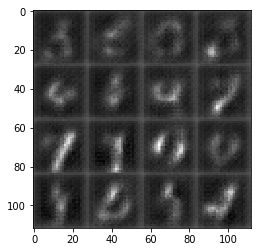

Epoch 2/2... Discriminator Loss: 0.3696... Generator Loss: 0.3633
Epoch 2/2... Discriminator Loss: 0.3809... Generator Loss: 0.3510
Epoch 2/2... Discriminator Loss: 0.3628... Generator Loss: 0.3865
Epoch 2/2... Discriminator Loss: 0.3550... Generator Loss: 0.3960
Epoch 2/2... Discriminator Loss: 0.3770... Generator Loss: 0.3614
Epoch 2/2... Discriminator Loss: 0.3617... Generator Loss: 0.3800
Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 0.5785
Epoch 2/2... Discriminator Loss: 0.3603... Generator Loss: 0.3810
Epoch 2/2... Discriminator Loss: 0.3613... Generator Loss: 0.3784
Epoch 2/2... Discriminator Loss: 0.4047... Generator Loss: 0.5184


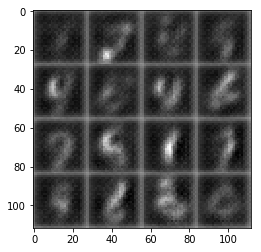

Epoch 2/2... Discriminator Loss: 0.3498... Generator Loss: 0.4144
Epoch 2/2... Discriminator Loss: 0.3607... Generator Loss: 0.4467
Epoch 2/2... Discriminator Loss: 0.3666... Generator Loss: 0.3688
Epoch 2/2... Discriminator Loss: 0.3508... Generator Loss: 0.4300
Epoch 2/2... Discriminator Loss: 0.3536... Generator Loss: 0.4040
Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 0.4409
Epoch 2/2... Discriminator Loss: 0.3718... Generator Loss: 0.3914
Epoch 2/2... Discriminator Loss: 0.3557... Generator Loss: 0.4209
Epoch 2/2... Discriminator Loss: 0.3529... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 0.4212... Generator Loss: 0.3367


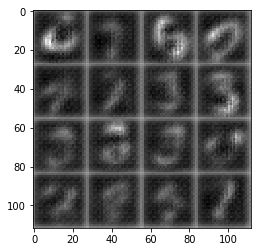

Epoch 2/2... Discriminator Loss: 0.3660... Generator Loss: 0.3869
Epoch 2/2... Discriminator Loss: 0.3721... Generator Loss: 0.5100
Epoch 2/2... Discriminator Loss: 0.3529... Generator Loss: 0.3973
Epoch 2/2... Discriminator Loss: 0.3423... Generator Loss: 0.4691
Epoch 2/2... Discriminator Loss: 0.3682... Generator Loss: 0.3671
Epoch 2/2... Discriminator Loss: 0.3421... Generator Loss: 0.4533
Epoch 2/2... Discriminator Loss: 0.3923... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 0.4581
Epoch 2/2... Discriminator Loss: 0.3468... Generator Loss: 0.4193
Epoch 2/2... Discriminator Loss: 0.3445... Generator Loss: 0.4486


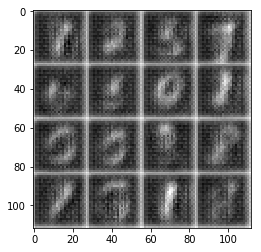

Epoch 2/2... Discriminator Loss: 0.4187... Generator Loss: 0.4632
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 0.4018
Epoch 2/2... Discriminator Loss: 0.3619... Generator Loss: 0.3849
Epoch 2/2... Discriminator Loss: 0.3537... Generator Loss: 0.3970
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 0.3326
Epoch 2/2... Discriminator Loss: 0.4059... Generator Loss: 0.4142
Epoch 2/2... Discriminator Loss: 0.3804... Generator Loss: 0.3760
Epoch 2/2... Discriminator Loss: 0.3898... Generator Loss: 0.3538
Epoch 2/2... Discriminator Loss: 0.3956... Generator Loss: 0.3489
Epoch 2/2... Discriminator Loss: 0.3890... Generator Loss: 0.3515


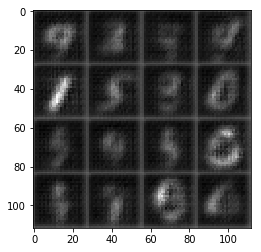

Epoch 2/2... Discriminator Loss: 0.3862... Generator Loss: 0.3594
Epoch 2/2... Discriminator Loss: 0.3834... Generator Loss: 0.3571
Epoch 2/2... Discriminator Loss: 0.3814... Generator Loss: 0.3628
Epoch 2/2... Discriminator Loss: 0.3780... Generator Loss: 0.3574
Epoch 2/2... Discriminator Loss: 0.3766... Generator Loss: 0.3658
Epoch 2/2... Discriminator Loss: 0.3755... Generator Loss: 0.3602


In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7685 Total loss: 2.1631


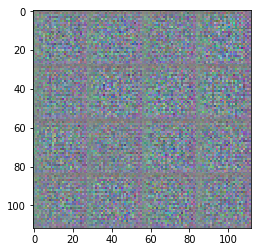

Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 0.3909 Total loss: 0.7676
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 0.4823 Total loss: 0.8562
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 0.4316 Total loss: 0.8081
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 0.3463 Total loss: 0.7905
Epoch 1/1... Discriminator Loss: 0.3839... Generator Loss: 0.4201 Total loss: 0.8040
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 0.3988 Total loss: 0.7987
Epoch 1/1... Discriminator Loss: 0.4020... Generator Loss: 0.3717 Total loss: 0.7737
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 0.3439 Total loss: 0.7543
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 0.3504 Total loss: 0.7467
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 0.3508 Total loss: 0.7573


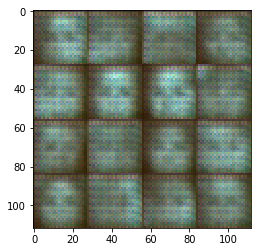

Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 0.3574 Total loss: 0.7562
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 0.3475 Total loss: 0.7454
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 0.3585 Total loss: 0.7565
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 0.3493 Total loss: 0.7538
Epoch 1/1... Discriminator Loss: 0.3915... Generator Loss: 0.3584 Total loss: 0.7499
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 0.3403 Total loss: 0.7578
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 0.3601 Total loss: 0.7539
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 0.3520 Total loss: 0.7496
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 0.3552 Total loss: 0.7523
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 0.3875 Total loss: 0.7768


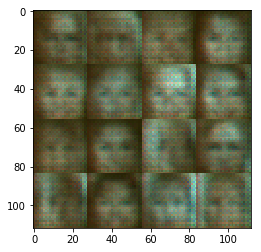

Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 0.3695 Total loss: 0.7768
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 0.3806 Total loss: 0.7699
Epoch 1/1... Discriminator Loss: 0.4392... Generator Loss: 0.4353 Total loss: 0.8745
Epoch 1/1... Discriminator Loss: 0.4064... Generator Loss: 0.3666 Total loss: 0.7730
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 0.3508 Total loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 0.3832 Total loss: 0.7771
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 0.3492 Total loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 0.3368 Total loss: 0.7448
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 0.3978 Total loss: 0.7921
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 0.3900 Total loss: 0.7773


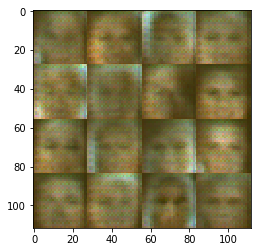

Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 0.4448 Total loss: 0.8939
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 0.3532 Total loss: 0.7459
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 0.3776 Total loss: 0.7592
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 0.3574 Total loss: 0.7441
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 0.3395 Total loss: 0.7336
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 0.3866 Total loss: 0.7780
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 0.3857 Total loss: 0.7614
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 0.3672 Total loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 0.5445 Total loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 0.3547 Total loss: 0.7490


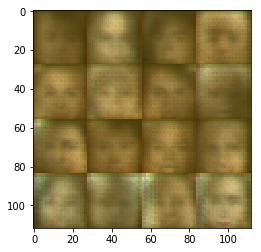

Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 0.3506 Total loss: 0.7474
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 0.3544 Total loss: 0.7526
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 0.3552 Total loss: 0.7489
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 0.3366 Total loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 0.3685 Total loss: 0.7687
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 0.3717 Total loss: 0.7479
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 0.3664 Total loss: 0.7594
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 0.3668 Total loss: 0.7632
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 0.3658 Total loss: 0.7532
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 0.3484 Total loss: 0.7467


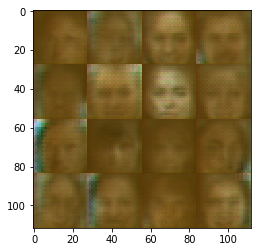

Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 0.3805 Total loss: 0.7596
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 0.3558 Total loss: 0.7463
Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 0.3553 Total loss: 0.7399
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 0.3553 Total loss: 0.7439
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 0.3703 Total loss: 0.7604
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 0.3711 Total loss: 0.7672
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 0.3568 Total loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 0.3567 Total loss: 0.7627
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 0.3512 Total loss: 0.7402
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 0.3697 Total loss: 0.7636


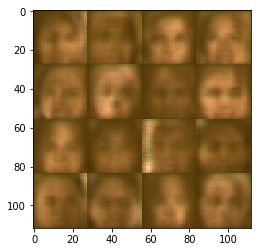

Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 0.3507 Total loss: 0.7490
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 0.3455 Total loss: 0.7447
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 0.3469 Total loss: 0.7459
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 0.3597 Total loss: 0.7479
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 0.3512 Total loss: 0.7500
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 0.3589 Total loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.4088... Generator Loss: 0.3512 Total loss: 0.7600
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 0.3578 Total loss: 0.7515
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 0.3445 Total loss: 0.7434
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 0.3608 Total loss: 0.7635


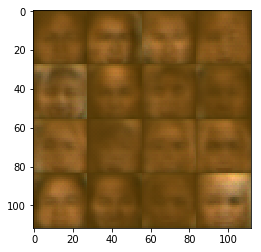

KeyboardInterrupt: 

In [16]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1 #

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:
print("OK")

OK
